In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import metrics
from numpy import linalg as LA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import time

In [2]:
df = pd.read_csv("optdigits_tran.csv", header=None)
df_test = pd.read_csv("optdigits_test.csv", header=None)

In [3]:
def my_pca(df):
    # Normalize:
    mean_centering_vector = df.mean()
    scaling_vector = (df - mean_centering_vector).std()
    for i in range(len(scaling_vector)):
        if scaling_vector[i] == 0:
            scaling_vector[i] =1
    X = df - mean_centering_vector
    X = X.div(scaling_vector)
    
    XX = np.dot(np.array(X).T, X)
    w, v = LA.eig(XX)
    components = v.T
    explained_variance_ratio = np.array([])
    for i in range(len(w)):
        R2 = w[i]/w.sum()
        explained_variance_ratio = np.append(explained_variance_ratio, R2)
        
    X_transform = np.dot(X, components.T)
    return X, pd.DataFrame(X_transform), components, explained_variance_ratio

In [4]:
def my_sfs(X, y, model, k_features):
    assert(k_features <= len(X.columns))
    X_selection = np.empty((0, len(X.index)))
    best_feature = np.array([])
    for i in range(k_features): # for loop to find k features
        error = np.array([]) # this error array contains total error for each col and select the col with min error
        for col in range(len(X.columns)):
            if not col in best_feature: # if tmp col selected in the best_feature, no need to check it again
                tmp_X = np.append(X_selection, np.array([X[col]]), axis = 0) # combine tmp col with best_features
                tmp_X = pd.DataFrame(tmp_X.T)
                model.fit(tmp_X, y)
                prediction = model.predict(tmp_X)
                error = np.append(error, sum(abs(prediction - y))) # fit and get error for this col
            else:
                error = np.append(error, math.inf) # if tmp col in best_feature, set infinite error, will not be selected
        best_feature = np.append(best_feature, np.argmin(error)) # add col index to best_feature
        X_selection = np.append(X_selection, np.array([X[best_feature[-1]]]), axis = 0) # add col to X_selected
    return pd.DataFrame(X_selection.T), best_feature

# Use pca and sfs to get k attributes datasets, and then classify the data and compare the results. 

In [5]:
X = df.drop(columns = 64)
y = df[64]
X_test = df_test.drop(columns = 64)
y_test = df_test[64]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4)

In [6]:
# pca_X, pca_y
# pca_X_train, pca_y_train
# pca_X_val, pca_y_val
# pca_X_test, pca_y_test

k_selected = 10

X_cs, X_transform, components, explained_variance_ratio = my_pca(X)
pca_X = X_transform.iloc[:, :k_selected]
pca_y = df[64]

X_cs, X_transform, components_waste, explained_variance_ratio = my_pca(X_test)
X_transform = pd.DataFrame(np.dot(X_cs, components.T))
pca_X_test = X_transform.iloc[:, :k_selected]
pca_y_test = df_test[64]

pca_X_train, pca_X_val, pca_y_train, pca_y_val = train_test_split(pca_X, y, test_size=0.2, random_state=4)

In [7]:
# sfs_X, sfs_y
# sfs_X_train, sfs_y_train
# sfs_X_val, sfs_y_val
# sfs_X_test, sfs_y_test

k_selected = 10
model = KNeighborsClassifier()

X_selection, best_feature = my_sfs(X, y, model, k_selected)
sfs_X = X_selection
sfs_y = df[64]

# X_selection, best_feature = my_sfs(X_test, y_test, model, k_selected)
sfs_X_test = X_test.iloc[:, best_feature]
sfs_y_test = df_test[64]
sfs_X_train, sfs_X_val, sfs_y_train, sfs_y_val = train_test_split(sfs_X, y, test_size=0.2, random_state=4)

# KNN

Maximum accuracy: 0.9895424836601308 at K = 3


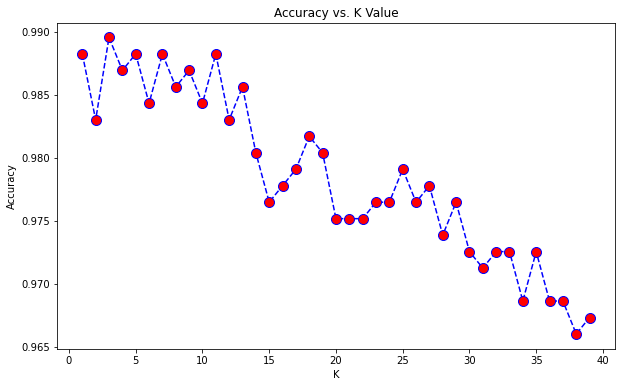

In [8]:
# KNeighborsClassifier
# https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb

error = []
accuracy = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
#     error.append(np.mean(pred_i != y_val))
    accuracy.append(knn.score(X_val, y_val))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),accuracy,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:", max(accuracy), "at K =", accuracy.index(max(accuracy))+1)
best_k = accuracy.index(max(accuracy))+1

In [9]:
knn = KNeighborsClassifier(n_neighbors = best_k)
tic1 = time.perf_counter()
knn.fit(X, y)
toc1 = time.perf_counter()
tic2 = time.perf_counter()
# knn.score(X_test, y_test)
knn_predict = knn.predict(X_test)
toc2 = time.perf_counter()
print("Accuracy for test data:", knn.score(X_test, y_test))
print(f"Training time in {toc1 - tic1:0.4f} seconds")
print(f"Testing time in {toc2 - tic2:0.4f} seconds")

Accuracy for test data: 0.9782971619365609
Training time in 0.0028 seconds
Testing time in 0.1511 seconds


PCA Maximum accuracy: 0.9424836601307189 at K = 5


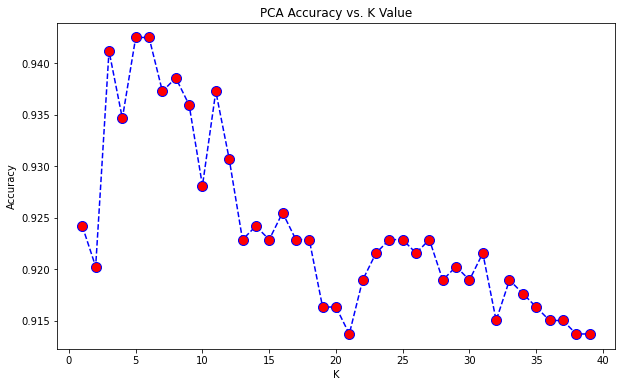

In [10]:
error = []
accuracy = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(pca_X_train, pca_y_train)
#     error.append(np.mean(pred_i != y_val))
    accuracy.append(knn.score(pca_X_val, pca_y_val))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),accuracy,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('PCA Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("PCA Maximum accuracy:", max(accuracy), "at K =", accuracy.index(max(accuracy))+1)
best_k = accuracy.index(max(accuracy))+1

In [11]:
knn = KNeighborsClassifier(n_neighbors = best_k)
# knn.fit(pca_X, pca_y)
# print("PCA Accuracy for test data:", knn.score(pca_X_test, pca_y_test))
tic1 = time.perf_counter()
knn.fit(pca_X, pca_y)
toc1 = time.perf_counter()
tic2 = time.perf_counter()
# knn.score(pca_X_test, pca_y_test)
knn_pca_predict = knn.predict(pca_X_test)
toc2 = time.perf_counter()
print("PCA Accuracy for test data:", knn.score(pca_X_test, pca_y_test))
print(f"Training time in {toc1 - tic1:0.4f} seconds")
print(f"Testing time in {toc2 - tic2:0.4f} seconds")

PCA Accuracy for test data: 0.9276572064552031
Training time in 0.0051 seconds
Testing time in 0.0772 seconds


SFS Maximum accuracy: 0.8718954248366013 at K = 5


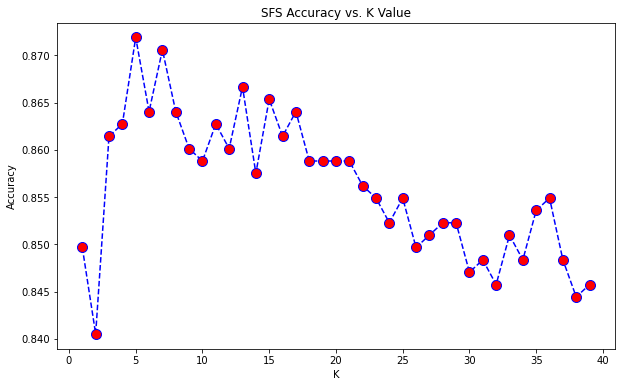

In [12]:
error = []
accuracy = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(sfs_X_train, sfs_y_train)
#     error.append(np.mean(pred_i != y_val))
    accuracy.append(knn.score(sfs_X_val, sfs_y_val))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),accuracy,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('SFS Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("SFS Maximum accuracy:", max(accuracy), "at K =", accuracy.index(max(accuracy))+1)
best_k = accuracy.index(max(accuracy))+1

In [13]:
knn = KNeighborsClassifier(n_neighbors = best_k)
tic1 = time.perf_counter()
knn.fit(sfs_X, sfs_y)
toc1 = time.perf_counter()
tic2 = time.perf_counter()
# knn.score(sfs_X_test, sfs_y_test)
knn_sfs_predict = knn.predict(sfs_X_test)
toc2 = time.perf_counter()
print("SFS Accuracy for test data:", knn.score(sfs_X_test, sfs_y_test))
print(f"Training time in {toc1 - tic1:0.4f} seconds")
print(f"Testing time in {toc2 - tic2:0.4f} seconds")

SFS Accuracy for test data: 0.8313856427378965
Training time in 0.0088 seconds
Testing time in 0.0731 seconds


# SVM

In [14]:
# svm (Support Vector Machines)

svc = svm.SVC(decision_function_shape='ovr')
tic1 = time.perf_counter()
svc.fit(X, y)
toc1 = time.perf_counter()
tic2 = time.perf_counter()
# svc.score(X_test, y_test)
svm_predict = svc.predict(X_test)
toc2 = time.perf_counter()
print("Accuracy for test data:", svc.score(X_test, y_test))
print(f"Training time in {toc1 - tic1:0.4f} seconds")
print(f"Testing time in {toc2 - tic2:0.4f} seconds")

Accuracy for test data: 0.9760712298274903
Training time in 0.1380 seconds
Testing time in 0.3415 seconds


In [15]:
# Those are the model with bad parameters:

# svc = svm.SVC(decision_function_shape='ovo')
# svc.fit(X, y)
# print("Accuracy for test data:", svc.score(X_test, y_test))

# svc = svm.LinearSVC()
# svc.fit(X, y)
# print("Accuracy for test data:", svc.score(X_test, y_test))

# svc = svm.NuSVC()
# svc.fit(X, y)
# print("Accuracy for test data:", svc.score(X_test, y_test))

# linear_svc = svm.SVC(kernel='linear')
# linear_svc.fit(X, y)
# print("Accuracy for test data:", linear_svc.score(X_test, y_test))

# poly_svc = svm.SVC(kernel='poly')
# poly_svc.fit(X, y)
# print("Accuracy for test data:", poly_svc.score(X_test, y_test))

# clf = make_pipeline(StandardScaler(), svm.SVC())
# clf.fit(X, y)
# print("Accuracy for test data:", clf.score(X_test, y_test))

# def my_kernel(X, Y):
#     return np.dot(X, Y.T)
# clf = svm.SVC(kernel=my_kernel)
# clf.fit(X, y)
# print("Accuracy for test data:", clf.score(X_test, y_test))

In [16]:
svc = svm.SVC()
tic1 = time.perf_counter()
svc.fit(pca_X, pca_y)
toc1 = time.perf_counter()
tic2 = time.perf_counter()
# svc.score(pca_X_test, pca_y_test)
svc_pca_predict = svc.predict(pca_X_test)
toc2 = time.perf_counter()
print("PCA Accuracy for test data:", svc.score(pca_X_test, pca_y_test))
print(f"Training time in {toc1 - tic1:0.4f} seconds")
print(f"Testing time in {toc2 - tic2:0.4f} seconds")

PCA Accuracy for test data: 0.9376739009460211
Training time in 0.1412 seconds
Testing time in 0.2358 seconds


In [17]:
svc = svm.SVC()
tic1 = time.perf_counter()
svc.fit(sfs_X, sfs_y)
toc1 = time.perf_counter()
tic2 = time.perf_counter()
# svc.score(sfs_X_test, sfs_y_test)
svc_sfs_predict = svc.predict(sfs_X_test)
toc2 = time.perf_counter()
print("SFS Accuracy for test data:", svc.score(sfs_X_test, sfs_y_test))
print(f"Training time in {toc1 - tic1:0.4f} seconds")
print(f"Testing time in {toc2 - tic2:0.4f} seconds")

SFS Accuracy for test data: 0.8452977184195882
Training time in 0.1763 seconds
Testing time in 0.3191 seconds


# Confusion matrix

In [18]:
# Each row represents each attributes(0 to 9).
# Class in Testing data:
# 0:  178
# 1:  182
# 2:  177
# 3:  183
# 4:  181
# 5:  182
# 6:  181
# 7:  179
# 8:  174
# 9:  180

In [19]:
# KNN confusion matrix for PCA data and SFS data:
knn_pca_cm = metrics.confusion_matrix(pca_y_test, knn_pca_predict)
knn_pca_cm

array([[177,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0, 174,   4,   0,   0,   0,   3,   0,   1,   0],
       [  0,   4, 166,   0,   1,   0,   0,   4,   2,   0],
       [  0,   0,   1, 159,   1,   1,   0,   2,   8,  11],
       [  0,   1,   0,   0, 176,   0,   0,   0,   3,   1],
       [  0,   0,   0,   0,   1, 176,   1,   0,   0,   4],
       [  3,   2,   0,   0,   0,   0, 176,   0,   0,   0],
       [  0,   0,   0,   0,   5,   0,   0, 170,   2,   2],
       [  0,  13,   1,   8,   0,   4,   0,   1, 144,   3],
       [  0,   0,   0,  15,   0,  11,   0,   1,   4, 149]])

In [20]:
knn_sfs_cm = metrics.confusion_matrix(sfs_y_test, knn_sfs_predict)
knn_sfs_cm

array([[177,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0, 150,   5,   9,   3,   6,   1,   2,   2,   4],
       [  0,   3, 155,  10,   0,   5,   0,   3,   1,   0],
       [  1,  18,  23, 134,   0,   0,   0,   3,   1,   3],
       [  0,  15,   1,   1, 150,   1,   4,   5,   2,   2],
       [  1,   2,   3,   0,  10, 143,  18,   0,   3,   2],
       [  0,   2,   2,   1,   3,   3, 170,   0,   0,   0],
       [  0,   0,  10,   0,  16,   0,   0, 149,   1,   3],
       [  2,  14,   4,  12,   7,   0,   0,   1, 126,   8],
       [  2,   2,   3,   1,   4,   2,   0,   2,  24, 140]])

In [21]:
# SVM confusion matrix for PCA data and SFS data:
svm_pca_cm = metrics.confusion_matrix(pca_y_test, svc_pca_predict)
svm_pca_cm

array([[177,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0, 178,   0,   0,   0,   0,   1,   0,   3,   0],
       [  0,   5, 168,   0,   1,   0,   0,   2,   1,   0],
       [  0,   0,   1, 159,   0,   2,   0,   3,   4,  14],
       [  0,   1,   0,   0, 177,   0,   0,   0,   3,   0],
       [  0,   0,   0,   1,   1, 177,   0,   0,   1,   2],
       [  3,   1,   0,   0,   0,   0, 176,   0,   1,   0],
       [  0,   1,   0,   0,   5,   1,   0, 169,   2,   1],
       [  0,  12,   0,   9,   0,   1,   0,   0, 143,   9],
       [  0,   1,   0,  12,   0,   3,   0,   1,   2, 161]])

In [22]:
svm_sfs_cm = metrics.confusion_matrix(sfs_y_test, svc_sfs_predict)
svm_sfs_cm

array([[176,   0,   0,   0,   1,   1,   0,   0,   0,   0],
       [  0, 145,   3,  10,   2,  10,   2,   0,   3,   7],
       [  0,   4, 154,   8,   0,   6,   0,   4,   1,   0],
       [  0,  10,  14, 147,   0,   1,   0,   5,   2,   4],
       [  0,  15,   0,   0, 153,   2,   4,   3,   2,   2],
       [  0,   2,   0,   0,   9, 142,  23,   0,   4,   2],
       [  0,   1,   1,   1,   4,   2, 171,   0,   1,   0],
       [  0,   0,   4,   0,  13,   0,   1, 158,   1,   2],
       [  1,  12,   3,  11,   5,   0,   0,   2, 132,   8],
       [  1,   1,   3,   3,   5,   1,   0,   1,  24, 141]])